In [ ]:
!git clone https://github.com/anonICLR2020/node.git
%cd node
!pip install -r requirements.txt
!pip install lib
!pip install category_encoders
!pip install qhoptim
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import lib
import matplotlib.pyplot as plt
%matplotlib inline
from qhoptim.pyt import QHAdam
from category_encoders import LeaveOneOutEncoder
import torch, torch.nn as nn
import torch.nn.functional as F
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'



Cloning into 'node'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), done.
/content/node
     - 6.5 MB 995 kB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55.4 MB 1.2 MB/s 
     |████████████████████████████████| 16.6 MB 226 kB/s 
     |████████████████████████████████| 124 kB 57.5 MB/s 
  Created wheel for qhoptim: filename=qhoptim-1.1.0-py3-none-any.whl size=20333 sha256=458749de93a8f9e54ca7eec56b5be28f3d241cf4d5a490fe8f17f178210b65c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-03zoa225/wheels/4e/8d/ab/172397a202926a7ebf44245fdb7e8c91fb85d3108fb0b556f9
Successfully built qhoptim
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


  Created wheel for lib: filename=lib-3.0.0-py3-none-any.whl size=3211 sha256=c435527d3b655564331d81eb9ce62fd6ff1356546a44fb34a1002ba013cf454f
  Stored in directory: /root/.cache/pip/wheels/25/b5/ab/77080f348dcc198f90094558ced693d7c61f44812520a8db2e
Successfully built lib
     |████████████████████████████████| 82 kB 470 kB/s 
env: CUDA_VISIBLE_DEVICES=0,1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
experiment_name = 'ICFES Saber 11'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

experiment: ICFES Saber 11_2021.11.25_08:50


In [ ]:

#mount drive
from google.colab import drive
drive.mount("/content/drive/")
#read file
df = pd.read_csv('/content/drive/MyDrive/Thesis/df_cleaned.csv',sep=",",header=0,index_col=False)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#train-valid-test
train = df
target = 'total_score'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.98, .01, .01], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

s = (df.dtypes == 'object')
categorical_columns = list(s[s].index)
unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat+[target]] 
categorical_columns = categorical_columns[:-1]

In [ ]:
X_train = train.loc[train_indices,features]
y_train = train.loc[train_indices,target].values

X_valid = train.loc[valid_indices,features]
y_valid = train.loc[valid_indices,target].values

X_test = train.loc[test_indices,features]
y_test = train.loc[test_indices,target].values

In [ ]:
in_features = X_train.shape[1]
mu, std = y_train.mean(), y_train.std()
print("mean = %.5f, std = %.5f" % (mu, std))

normalize = lambda x: ((x - mu) / std).astype(np.float32)
y_train, y_valid, y_test = map(normalize, [y_train, y_valid, y_test])

mean = 252.82216, std = 51.11198


In [ ]:
cat_encoder = LeaveOneOutEncoder()
cat_encoder.fit(X_train[categorical_columns], y_train)
X_train[categorical_columns] = cat_encoder.transform(X_train[categorical_columns])
X_valid[categorical_columns] = cat_encoder.transform(X_valid[categorical_columns])
X_test[categorical_columns] = cat_encoder.transform(X_test[categorical_columns])
X_train=X_train.values.astype('float32')
X_valid=X_valid.values.astype('float32')
X_test=X_test.values.astype('float32')


In [ ]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
X_valid = torch.from_numpy(X_valid).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
y_valid = torch.from_numpy(y_valid).float()

In [ ]:
#establish model
model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train[:1000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

/content/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)


In [ ]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [ ]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 1000
report_frequency = 100

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

<Figure size 432x288 with 0 Axes>

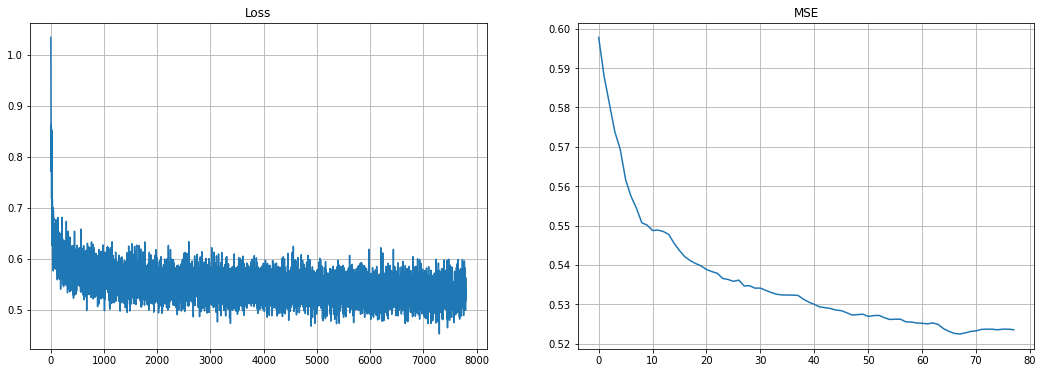

Loss 0.52502
Val MSE: 0.52353
BREAK. There is no improvment for 1000 steps
Best step:  6800
Best Val MSE: 0.52245


<Figure size 432x288 with 0 Axes>

In [ ]:
for batch in lib.iterate_minibatches(X_train, y_train, batch_size=1024, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            X_valid, y_valid, device=device, batch_size=2048)
        gc.collect()
        torch.cuda.empty_cache()

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        plt.savefig("NODE_performance.png", dpi=100)
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [ ]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(X_test, y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/ICFES Saber 11_2021.11.25_08:50/checkpoint_best_mse.pth
Best step:  6800
Test MSE: 0.53545


In [ ]:
#MSE on test
mse * std ** 2

1398.832955389333